** This notebook assumes you ran the Movement_Decoding_Deep_Net notebook and saved the model params**

In [2]:
%load_ext autoreload
%autoreload 2
import numpy as np
import theano
import matplotlib
from matplotlib import pyplot
from matplotlib import cm
%matplotlib inline
%config InlineBackend.figure_format = 'png' 
matplotlib.rcParams['figure.figsize'] = (12.0, 1.0)
matplotlib.rcParams['font.size'] = 7

import matplotlib.lines as mlines
import seaborn
seaborn.set_style('darkgrid')
import logging
log = logging.getLogger()
log.setLevel('DEBUG')
from braindecode.scripts.train_experiments import setup_logging
setup_logging()

Using gpu device 0: GeForce GTX TITAN X (CNMeM is disabled, cuDNN 5005)
/home/schirrmr/.local/lib/python2.7/site-packages/matplotlib/__init__.py:913: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


### Load data as in paper

In [3]:
C_sensors = ['FFC5h', 'FFC3h', 'FFC1h', 'FFC2h', 'FFC4h', 'FFC6h',
             'FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6',
             'FCC5h', 'FCC3h', 'FCC1h', 'FCC2h', 'FCC4h', 'FCC6h',
             'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6',
             'CCP5h', 'CCP3h', 'CCP1h', 'CCP2h', 'CCP4h', 'CCP6h',
             'CP5', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'CP6',
             'CPP5h', 'CPP3h', 'CPP1h', 'CPP2h', 'CPP4h', 'CPP6h']
#C_sensors = ['C3', 'Cz', 'C4'] # for faster debugging
#load_sensor_names = None # we always did cleaning on full set to be able to compare different sensor montages fairly
# but to make it faster let's now not do this:
load_sensor_names = C_sensors

In [4]:
from braindecode.datasets.combined import CombinedCleanedSet
from braindecode.mywyrm.processing import resample_cnt, bandpass_cnt, exponential_standardize_cnt

from braindecode.datasets.combined import CombinedCleanedSet

from braindecode.mywyrm.processing import resample_cnt, bandpass_cnt, exponential_standardize_cnt

from braindecode.datasets.cnt_signal_matrix import CntSignalMatrix
from braindecode.datasets.signal_processor import SignalProcessor
from braindecode.datasets.loaders import BBCIDataset
train_filename = 'data/BBCI-without-last-runs/BhNoMoSc1S001R01_ds10_1-12.BBCI.mat'
test_filename = 'data/BBCI-only-last-runs/BhNoMoSc1S001R13_ds10_1-2BBCI.mat'

# trial ivan in milliseconds
# these are the samples that will be predicted, so for a 
# network with 2000ms receptive field
# 1500 means the first receptive field goes from -500 to 1500
segment_ival = [1500,4000]


train_loader = BBCIDataset(train_filename, load_sensor_names=load_sensor_names)
test_loader = BBCIDataset(test_filename, load_sensor_names=load_sensor_names)

# Preprocessing pipeline in [(function, {args:values)] logic
from wyrm.processing import select_channels
cnt_preprocessors = [
    (select_channels , {
        'invert': True, 
        'regexp_list': ['Cz']
    },),
    (resample_cnt , {'newfs': 250.0}),
    (bandpass_cnt, {
        'low_cut_hz': 0,
        'high_cut_hz': 250,
     }),
     (exponential_standardize_cnt, {})
]

marker_def = {'1- Right Hand': [1],  '2 - Left Hand': [2], '3 - Rest': [3],
                                               '4 - Feet': [4]}

train_signal_proc = SignalProcessor(set_loader=train_loader, segment_ival=segment_ival,
                                   cnt_preprocessors=cnt_preprocessors,
                                   marker_def=marker_def)
train_set = CntSignalMatrix(signal_processor=train_signal_proc, sensor_names=C_sensors)

test_signal_proc = SignalProcessor(set_loader=test_loader, segment_ival=segment_ival,
                                   cnt_preprocessors=cnt_preprocessors,
                                   marker_def=marker_def)
test_set = CntSignalMatrix(signal_processor=test_signal_proc, sensor_names=C_sensors)

from braindecode.mywyrm.clean import MaxAbsCleaner
train_cleaner = MaxAbsCleaner(segment_ival=[0,4000], threshold=800, marker_def=marker_def)
test_cleaner = MaxAbsCleaner(segment_ival=[0,4000], threshold=800, marker_def=marker_def)
combined_set = CombinedCleanedSet(train_set, test_set,train_cleaner, test_cleaner)


In [5]:
combined_set.load()

2017-04-28 17:45:57,341 Load Training Set...
2017-04-28 17:46:08,103 Load Test Set...
2017-04-28 17:46:10,117 Clean Training Set...
2017-04-28 17:46:10,651 Rejected channels: []
2017-04-28 17:46:10,652 #Clean trials:     895
2017-04-28 17:46:10,653 #Rejected trials:  2
2017-04-28 17:46:10,654 Fraction Clean:    99.0%
2017-04-28 17:46:10,654 (from maxmin):     2
2017-04-28 17:46:10,655 (from var):        0
2017-04-28 17:46:10,781 Clean Test Set...
2017-04-28 17:46:10,874 Rejected channels: []
2017-04-28 17:46:10,875 #Clean trials:     160
2017-04-28 17:46:10,876 #Rejected trials:  0
2017-04-28 17:46:10,877 Fraction Clean:    100.0%
2017-04-28 17:46:10,877 (from maxmin):     0
2017-04-28 17:46:10,878 (from var):        0
2017-04-28 17:46:10,879 Create Cleaned Cnt Sets...
2017-04-28 17:46:11,699 Create sets from cleaned cnt...
2017-04-28 17:46:11,701 Preprocess continuous signal...
2017-04-28 17:46:23,045 Not doing any bandpass, since low 0 or None and high None or current fs
2017-04-28 1

### Define the model

In [6]:
from braindecode.models.deep5 import Deep5Net
from braindecode.veganlasagne.layer_util import print_layers
from lasagne.nonlinearities import elu,softmax,identity
from numpy.random import RandomState
import lasagne
in_chans = train_set.get_topological_view().shape[1]
input_time_length = 1000 # implies how many crops are processed in parallel, does _not_ determine receptive field size
# receptive field size is determined by model architecture
num_filters_time = 25
filter_time_length = 10
num_filters_spat = 25
pool_time_length = 3
pool_time_stride = 3
num_filters_2 = 50
filter_length_2 = 10
num_filters_3 = 100
filter_length_3 = 10
num_filters_4 = 200
filter_length_4 = 10
final_dense_length = 2
n_classes = 4
final_nonlin=softmax
first_nonlin=elu
first_pool_mode='max',
first_pool_nonlin=identity
later_nonlin=elu
later_pool_mode='max'
later_pool_nonlin=identity
drop_in_prob=0.0
drop_prob=0.5
batch_norm_alpha=0.1
double_time_convs=False
split_first_layer=True
batch_norm=True
# ensure reproducibility by resetting lasagne/theano random generator .. not really necessary in this notebook
lasagne.random.set_rng(RandomState(34734))

d5net = Deep5Net(in_chans=in_chans, input_time_length=input_time_length, num_filters_time=num_filters_time,
         filter_time_length=filter_time_length,
         num_filters_spat=num_filters_spat, pool_time_length=pool_time_length, pool_time_stride=pool_time_stride,
         num_filters_2=num_filters_2, filter_length_2=filter_length_2,
         num_filters_3=num_filters_3, filter_length_3=filter_length_3,
         num_filters_4=num_filters_4, filter_length_4=filter_length_4,
         final_dense_length=final_dense_length, n_classes=n_classes,
         final_nonlin=final_nonlin, first_nonlin=first_nonlin,
         first_pool_mode='max', first_pool_nonlin=first_pool_nonlin,
         later_nonlin=later_nonlin, later_pool_mode='max', later_pool_nonlin=later_pool_nonlin,
         drop_in_prob=drop_in_prob, drop_prob=drop_prob, batch_norm_alpha=batch_norm_alpha,
         double_time_convs=double_time_convs,  split_first_layer=split_first_layer, batch_norm=batch_norm)
final_layer = d5net.get_layers()[-1]
print_layers(final_layer)

 0-InputLayer                                                         (None, 44, 1000, 1)
 1-DimshuffleLayer                                                    (None, 1, 1000, 44)
 2-DropoutLayer             0.000                                    
 3-Conv2DLayer              10x1                                      (None, 25, 991, 44)
 4-Conv2DAllColsLayer       1x44                                      (None, 25, 991, 1)
 5-BatchNormLayer                                     elu            
 6-Pool2DLayer              3x1                       max             (None, 25, 989, 1)
 7-StrideReshapeLayer           ::3 ::1                               (None, 25, 330, 1)
 8-NonlinearityLayer                                                 
 9-DropoutLayer             0.500                                    
10-Conv2DLayer              10x1                                      (None, 50, 321, 1)
11-BatchNormLayer                                     elu            
12-Pool2DLayer          

### Define how to split into train/valid/Test and how to iterate over data

In [7]:
from braindecode.datahandling.splitters import SeveralSetsSplitter
dataset_splitter = SeveralSetsSplitter(valid_set_fraction=0.2, use_test_as_valid=False)
datasets = dataset_splitter.split_into_train_valid_test(combined_set)
from braindecode.datahandling.batch_iteration import CntWindowTrialIterator
from braindecode.veganlasagne.layers import get_n_sample_preds
iterator = CntWindowTrialIterator(batch_size=45,input_time_length=input_time_length,
                                 n_sample_preds=get_n_sample_preds(final_layer))

### set model params to the saved trained model params

In [8]:
lasagne.layers.set_all_param_values(final_layer, np.load('./tutorial-movement-model-params.npy'))

### Perturbation


I will here do it in a slightly simpler way than in the paper: I will not have any notion of trials, just perturb crops and see how it changes the prediction. I will do it on the test set since it is faster, but you can do it exactly the same way as on the train set

#### Get test batches

In [9]:
test_batches = list(iterator.get_batches(datasets['test'], shuffle=False))


#### Create prediction function

In [10]:
# Let's use the layer before softmax. Also use the unflattened version so
# it is easy to attribute which prediction comes from which crop
from braindecode.veganlasagne.layers import FinalReshapeLayer
prediction_layer = FinalReshapeLayer(final_layer.input_layer.input_layer, flatten=False)

In [11]:
import theano.tensor as T
in_var = T.ftensor4()

out = lasagne.layers.get_output(prediction_layer, inputs=in_var, input_var=in_var)

pred_fn = theano.function([in_var], out)

#### remember original predictions

In [12]:
original_preds = np.concatenate([pred_fn(b[0]) for b in test_batches])

#### sanity check for accuracy

In [13]:
all_targets = np.concatenate(zip(*test_batches)[1])

labels_per_sample = np.argmax(all_targets.reshape(original_preds.swapaxes(1,2).shape),2)

pred_label_per_sample = np.argmax(original_preds.swapaxes(1,2),2)

print("{:.2f}% samplewise accuracy".format(np.mean(labels_per_sample == pred_label_per_sample) * 100))

96.05% samplewise accuracy


#### Get amplitudes and phases

In [14]:
# b[1] are y values
ffted_batches = [np.fft.rfft(b[0], axis=2) for b in test_batches]
all_amplitudes = [np.abs(ffted) for ffted in ffted_batches]
all_phases = [np.angle(ffted) for ffted in ffted_batches]

### sanity check

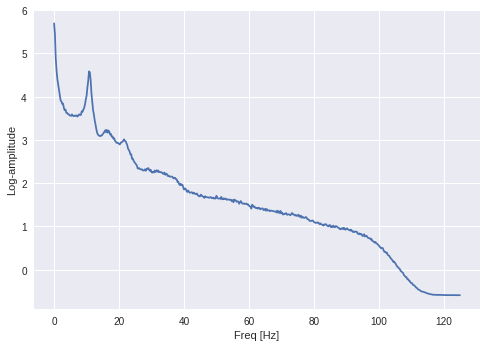

In [21]:
import matplotlib.pyplot as plt
freqs = np.fft.rfftfreq(1000, 1/250.0)
plt.plot(freqs, np.log(np.median(np.abs(np.concatenate(all_amplitudes)), axis=(0,1,3))))
plt.xlabel("Freq [Hz]")
plt.ylabel("Log-amplitude")


In [22]:
from braindecode.datasets.fft import amplitude_phase_to_complex
from braindecode.analysis.stats import wrap_reshape_topo, corr
n_perturbation_iterations = 100
rng = RandomState(49587489)
all_pred_amp_corrs = []
for i_iteration in range(n_perturbation_iterations):
    log.info("Computing iteration {:d}".format(i_iteration))
    all_new_preds = []
    all_perturbations = []
    for amps, phases in zip(all_amplitudes, all_phases):
        assert len(amps) == len(phases)
        perturbation = rng.randn(*amps.shape)
        # clip in case diff would move amplitudes to negative region
        # np.maximum is elementwise max
        perturbation = np.maximum(-amps, perturbation)
        all_perturbations.append(perturbation)
        new_amps = amps + perturbation
        assert np.all(new_amps >= 0)
        new_input = np.fft.irfft(amplitude_phase_to_complex(new_amps, phases), axis=2)
        new_preds = pred_fn(new_input.astype(np.float32))
        all_new_preds.append(new_preds)
    all_new_preds = np.concatenate(all_new_preds)
    # also show current accuracy
    all_targets = np.concatenate(zip(*test_batches)[1])
    labels_per_sample = np.argmax(all_targets.reshape(original_preds.swapaxes(1,2).shape),2)
    pred_label_per_sample = np.argmax(all_new_preds.swapaxes(1,2),2)
    log.info("{:.2f}% samplewise accuracy".format(np.mean(labels_per_sample == pred_label_per_sample) * 100))
    all_perturbations = np.concatenate(all_perturbations)
    pred_diffs = all_new_preds - original_preds
    pred_diffs = np.mean(pred_diffs, axis=2, keepdims=True)
    pred_amp_corrs = wrap_reshape_topo(corr, pred_diffs.squeeze(), all_perturbations.squeeze(),
                                           axis_a=(0), axis_b=(0))
    # -> classes x sensors x freqs
    all_pred_amp_corrs.append(pred_amp_corrs)

2017-04-28 17:49:04,086 Computing iteration 0
2017-04-28 17:49:05,890 95.48% samplewise accuracy
2017-04-28 17:49:06,007 Computing iteration 1
2017-04-28 17:49:07,791 95.89% samplewise accuracy
2017-04-28 17:49:07,907 Computing iteration 2
2017-04-28 17:49:09,684 95.85% samplewise accuracy
2017-04-28 17:49:09,784 Computing iteration 3
2017-04-28 17:49:11,563 95.55% samplewise accuracy
2017-04-28 17:49:11,659 Computing iteration 4
2017-04-28 17:49:13,457 95.58% samplewise accuracy
2017-04-28 17:49:13,557 Computing iteration 5
2017-04-28 17:49:15,333 95.53% samplewise accuracy
2017-04-28 17:49:15,447 Computing iteration 6
2017-04-28 17:49:17,232 95.79% samplewise accuracy
2017-04-28 17:49:17,346 Computing iteration 7
2017-04-28 17:49:19,112 95.58% samplewise accuracy
2017-04-28 17:49:19,225 Computing iteration 8
2017-04-28 17:49:21,001 95.47% samplewise accuracy
2017-04-28 17:49:21,119 Computing iteration 9
2017-04-28 17:49:22,889 95.74% samplewise accuracy
2017-04-28 17:49:23,004 Comput

In [25]:
mean_pred_amp_corr = np.mean(all_pred_amp_corrs, axis=0)

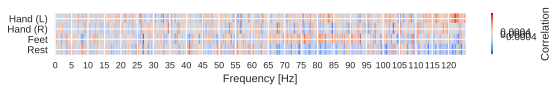

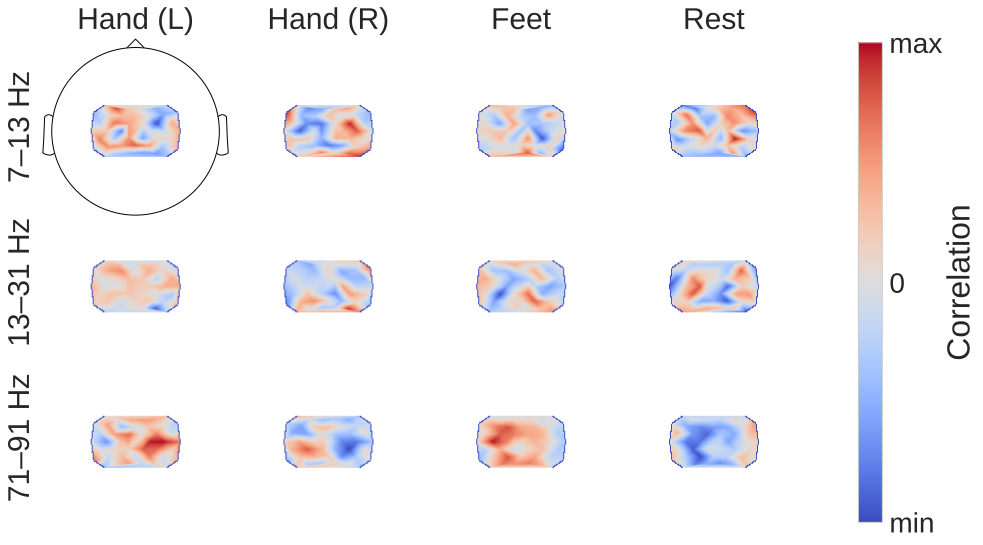

In [26]:
from braindecode.paper import map_i_class, permute_order_i_class, resorted_class_names
from braindecode.paper.plot import plot_scalp_grid, add_colorbar_to_scalp_grid
seaborn.set_style('darkgrid')
%config InlineBackend.figure_format = 'svg' 
class_names = resorted_class_names

freq_bands = (7,13), (13,31), (71,91)
freq_strs = [u"{:d}–{:d} Hz".format(low,high) for low, high in freq_bands]

cmap = cm.coolwarm
scale_per_class = False
scale_individually = True
merge_func = np.mean
corrs = mean_pred_amp_corr[permute_order_i_class][None] # to conform to paper code logic
# draw image
plt.figure(figsize=(8,1.2))
freq_classes_corrs = merge_func(corrs, axis=(0,2))
im = plt.imshow(freq_classes_corrs, cmap=cm.coolwarm, interpolation='nearest',
          aspect='auto', vmin=-np.max(np.abs(freq_classes_corrs)), 
                vmax=np.max(np.abs(freq_classes_corrs)))
plt.xticks(range(500)[::20], freqs[::20].astype(np.int32), fontsize=9)
plt.yticks(range(4), class_names)
cbar = plt.colorbar(im)#, orientation='horizontal')
cbar.set_ticks(np.arange(-4e-4,4e-4+1e-6,4e-4))
cbar.set_label('Correlation')
plt.xlabel('Frequency [Hz]')
plt.tight_layout()
None

seaborn.set_style('whitegrid') # helpful for weird pdf viewers
freq_amp_corrs = []
for i_freq, (freq_low, freq_high) in enumerate(freq_bands):
    i_freq_start = freqs.tolist().index(freq_low)
    i_freq_stop = freqs.tolist().index(freq_high) + 1
    freq_amp_corrs.append([])
    for i_class in xrange(4):
        freq_amp_corrs[-1].append(merge_func(corrs[:,i_class,:,i_freq_start:i_freq_stop], axis=(0,2)))
freq_amp_corrs = np.array(freq_amp_corrs)
fig,axes = plot_scalp_grid(freq_amp_corrs, test_set.sensor_names, scale_individually=True,
               col_names=class_names, row_names=freq_strs, figsize=(14,8),
                          fontsize=30)
fig.tight_layout()
fig.subplots_adjust(hspace=-0.3,wspace=0.)
cbar = add_colorbar_to_scalp_grid(fig, axes, label='Correlation',
                                 ticklabelsize=28,
                                 labelsize=32)


### Stuff for me (robin)

In [1]:
%%capture
import os
import site
site.addsitedir('/home/schirrmr/.local/lib/python2.7/site-packages/')
site.addsitedir('/usr/lib/pymodules/python2.7/')
os.sys.path.insert(0, '/home/schirrmr/braindecode/code/')
%cd /home/schirrmr/braindecode/code/braindecode/
assert 'THEANO_FLAGS' in os.environ
# switch to cpu
#os.environ['THEANO_FLAGS'] = 'floatX=float32,device=cpu,nvcc.fastmath=True'